In [57]:
#https://github.com/huridocs/pdf-document-layout-analysis/tree/main
import requests, json
from itertools import groupby
from typing import Dict
from enum import Enum
import camelot
model_api="http://192.168.2.186:5060"

class Color:
    Red = (255, 0, 0)
    Green = (0, 255, 0)
    Blue = (0, 0, 255)
    Yellow = (255, 255, 0)
    Cyan = (0, 255, 255)
    Magenta = (255, 0, 255)
    Purple = (128, 0, 128)
    Orange = (255, 165, 0)
    Seagreen = (46, 139, 87)
    Salmon = (250, 128, 114)
    Olive = (60, 76, 36)
    Lightpink = (255, 182, 193)

class LayoutType(Enum):
    Unknown = (0, "Footnote", Color.Red)
    Caption = (1, "Caption", Color.Purple)
    Footnote = (2, "Footnote", Color.Lightpink)
    Formula = (3, "Formula", Color.Green)
    List_item = (4, "List item", Color.Seagreen)
    Page_footer = (5, "Page footer", Color.Yellow)
    Page_header = (6, "Page header", Color.Salmon)
    Picture = (7, "Picture", Color.Magenta)
    Section_header = (8, "Section header", Color.Olive)
    Table = (9, "Table", Color.Cyan)
    Text = (10, "Text", Color.Blue)
    Title = (11, "Title", Color.Orange)

    @property
    def __number__(self) -> int:
        return self.value[0]  # Returns the numerical identifier

    @property
    def __type__(self) -> str:
        return self.value[1]  # Returns the type

    @property
    def __color__(self) -> tuple[int, int, int]:
        return self.value[2]  # Returns the color

    @staticmethod
    def get_type(detection_result):
        detection_type = detection_result.get("type", "empty").replace(" ","_")
        try:
            # return getattr(LayoutType, detection_type)
            return LayoutType[detection_type]
        except KeyError:
            logging.warning(f"Invalid layout type {detection_type}")
            return LayoutType.Unknown

    @staticmethod
    def get_bbox_info(detection_result):
        return [detection_result['left'], 
                detection_result['top'], 
                detection_result['left'] + detection_result['width'],
                detection_result['top'] + detection_result['height']]

class Detection:
    @staticmethod
    def model_request(file_path):
        with open(file_path, 'rb') as file:
            files = {'file': file}
            response = requests.post(model_api, files=files)
        result=json.loads(response.text)
        detection_results = [{'page_number': key, 'detection_result': list(group)} 
                for key, group in groupby(sorted(result, key=lambda x: x['page_number']), lambda x: x['page_number'])]
        return detection_results

    @staticmethod
    def additional_table_detection(detected_result,file_path,page_width,page_height):
        def convert_pdfplumber_to_camelot(pdfplumber_bbox, page_height):
            new_x1, new_y1, new_x2, new_y2 = pdfplumber_bbox
            
            # 좌표 변환. 스케일링 없이 단순히 y축만 반전
            x1 = new_x1
            x2 = new_x2
            y1 = page_height - new_y2
            y2 = page_height - new_y1
            
            return [x1, y1, x2, y2]

        total_res=[]
        for dr in detected_result:
            tables = camelot.read_pdf(file_path, pages=str(dr["page_number"]), backend="poppler")
            page_res={"page_number":dr["page_number"],"detection_result":[]}
            for i in dr["detection_result"]:
                if i["layout"].__type__=="Table":
                    table_check_flag=False
                    pdfplumber_bbox=i["bbox"]
                    for table in tables:
                        if table.df[0][0]!="":
                            camelot_bbox=table._bbox
                            converted_pdfplumber_bbox=convert_pdfplumber_to_camelot(pdfplumber_bbox, page_height)
                            diff= abs(int(converted_pdfplumber_bbox[0])-int(camelot_bbox[0]))

                            if diff < 3:
                                i["text"]=table.df.to_markdown(index=False)
                                table_check_flag=True
                                page_res["detection_result"].append(i)

                    if table_check_flag==False:
                        page_res["detection_result"].append(i)
                else: page_res["detection_result"].append(i)
            
                    # TODO camelot으로도 추출되지 않는 table(주로 table이 낮은 해상도의 그림으로(드래그 되지 않는) 삽입되어 있는 경우)
                    # if table_check_flag==False:
                    #     PDF_FOR_TXT_EXTRACTION_page = PDF_FOR_TXT_EXTRACTION.load_page(dr["page_number"]-1)
                    #     PDF_FOR_TXT_EXTRACTION_page.get_textbox(pdfplumber_bbox)
            
            total_res.append(page_res)
        return total_res


class Layout:
    def __init__(self,detection_results,file_path):
        self.file_path=file_path
        self.detection_results=detection_results
        self.records: dict[detection_results, Any] = {page_num+1: [] for page_num in range(len(detection_results))}
        self.recovery=""" """
        self.page_width=None
        self.page_height=None
    
    def add(self,page_number,detection_info):
        try:
            self.records[page_number].append(detection_info)
        except Exception as e: 
            self.records[page_number]=[detection_info]

        layout_type=detection_info.get("layout").__type__
        text=detection_info.get("text")
        self.recovery += f"\n\n## [{layout_type.title()}]({text})\n\n" 

    def get_records(self):
        result = list(map(lambda item: {'page_number': item[0], 'detection_result': item[1]}, self.records.items()))
        result=Detection.additional_table_detection(result,self.file_path,self.page_width,self.page_height)
        return result

    def get_layout_infos(self):
        for page_detection_result in self.detection_results:
            page_number=page_detection_result["page_number"]
            for detection_result in page_detection_result["detection_result"]:
                self.add(page_number,self.get_layout_info(detection_result))
                self.page_width=detection_result["page_width"]
                self.page_height=detection_result["page_height"]

    def get_layout_info(self,detection_result):
        bbox_info = LayoutType.get_bbox_info(detection_result)
        layout_type = LayoutType.get_type(detection_result)

        # if len(detection_result["text"])==0:
            # detections, table, img = [], None, None
            # if layout_type == LayoutType.Table:
            #     detections = get_table_markdown(line,box,pdf_page,img_height,img_width,pdf_doc)
            # elif layout_type == LayoutType.Picture:
            #     detections, table_check_flag = get_detections(line,pdf_page,box,img_height,img_width,page_number,file_path)
            #     img = line.get("img")  # Currently not in use
            # else:
            #     detections, table_check_flag = get_detections(line,pdf_page,box,img_height,img_width,page_number,file_path)
            #     if table_check_flag==True:layout_type=LayoutType.TABLE
            # return layout_type, box, detections, table, img

        return {"bbox":bbox_info,
                "page_number":detection_result["page_number"],
                "text":detection_result["text"],
                "layout":layout_type}

In [58]:
from collections import defaultdict
from threading import Thread, Event
import json,os,random

final_res=[]
final_result=[]
res_check=[]

class RUN:
    def __init__(self):
        self.result = None
        self.result_ready = Event()

    def ocr(self,file_path):
        print("--- PDF PROCESSING ---")
        detection_results= Detection.model_request(file_path)
        print(detection_results)

        layout=Layout(detection_results,file_path)
        layout.get_layout_infos()
        self.result=layout.get_records()

        self.result_ready.set()

        merged_results = defaultdict(lambda: {'text': '', 'info': []})

        # self.final_res=[]
        # for fr in self.result:
        #     text_text = ""
        #     for dr in fr["detection_result"]:
        #         if dr["layout"].__type__=="Text":
        #             text_text += dr['text']

        #     for dr in fr["detection_result"]:
        #         if dr['layout'].__type__ == 'Table':
        #             dr['text'] += "\n\n" + text_text

        for fr in self.result:
            title = ""
            fin_resres={"page_number":fr["page_number"],"detection_result":[]}
            for dr in fr["detection_result"]:
                if dr["layout"].__type__=="Title" or dr["layout"].__type__=="Section header":
                    title=dr['text']
                # elif dr["layout"].__type__=="Text" or dr["layout"].__type__=="Table":
                else:
                    # if len(dr["text"])>5: # text minimum length
                    dr["title"] = title
                    fin_resres["detection_result"].append(dr)
            final_res.append(fin_resres)

        res_check.append(self.result)
        
        last_title = None  # 가장 최근의 title 저장
        for page in final_res:
            for result in page['detection_result']:
                title = result['title']
    
                # title이 빈 문자열이면 직전 title을 사용
                if title == "":
                    title = last_title
                else:
                    last_title = title
    
                # title을 기준으로 텍스트를 '\n'로 결합
                if merged_results[title]['text']:
                    merged_results[title]['text'] += '\n' + result['text']
                else:
                    merged_results[title]['text'] = result['text']
                
                # bbox, page_number, layout 정보 추가
                merged_results[title]['info'].append({
                    "bbox": result['bbox'],
                    "page_number": result['page_number'],
                    "layout": result['layout']
                })
    
        for title, content in merged_results.items():
            final_result.append({
                "title": title,
                "text": content['text'],
                "info": content['info']
            })

        
        # final_res.append(self.result)
        self.result_ready.set()

        print("--- OCR done ---")

    def threading_ocr_process(self,file_path: str):
        handle = Thread(target=self.ocr, args=[str(file_path)])
        handle.start()
        handle.join()

In [59]:
RUN().threading_ocr_process("/workspace/.gen/PDF_Parsing/costom_ocr_vgt/src/app/pdf_examples/<vgt>세로형PDF_(20240603) 금융시장 브리프.pdf")

--- PDF PROCESSING ---
[{'page_number': 1, 'detection_result': [{'left': 462.0, 'top': 206.0, 'width': 52.0, 'height': 11.0, 'page_number': 1, 'page_width': 595, 'page_height': 841, 'text': '2024.  6.  3.', 'type': 'Page header'}, {'left': 179.0, 'top': 157.0, 'width': 210.0, 'height': 26.0, 'page_number': 1, 'page_width': 595, 'page_height': 841, 'text': '6월  금융시장  브리프', 'type': 'Title'}, {'left': 64.0, 'top': 58.0, 'width': 101.0, 'height': 32.0, 'page_number': 1, 'page_width': 595, 'page_height': 841, 'text': '', 'type': 'Picture'}, {'left': 78.0, 'top': 116.0, 'width': 75.0, 'height': 15.0, 'page_number': 1, 'page_width': 595, 'page_height': 841, 'text': '', 'type': 'Text'}, {'left': 56.0, 'top': 234.0, 'width': 102.0, 'height': 14.0, 'page_number': 1, 'page_width': 595, 'page_height': 841, 'text': '[5월 금융시장 동향]', 'type': 'Text'}, {'left': 55.0, 'top': 254.0, 'width': 459.0, 'height': 28.0, 'page_number': 1, 'page_width': 595, 'page_height': 841, 'text': '5월중 국내 금융시장은 미 연준의 금리인하 기대

In [62]:
for aa in final_result:
    print(aa)
    print("\n////////////////////////////////////\n")

{'title': None, 'text': '2024.  6.  3.', 'info': [{'bbox': [462.0, 206.0, 514.0, 217.0], 'page_number': 1, 'layout': <LayoutType.Page_header: (6, 'Page header', (250, 128, 114))>}]}

////////////////////////////////////

{'title': '6월  금융시장  브리프', 'text': '[5월 금융시장 동향]\n5월중 국내 금융시장은 미 연준의 금리인하 기대감이 커지며 국고채금리가 하락하고 원화는 강세를  나타냈으며,  증시는  국내  매크로  개선  기대와  기술주  강세로  상승\n[최근 금융시장 주요 현안]\n①  미국보다  빠른  유럽의  금리인하:  ECB  6월초  금리인하  유력\nŸ 2%에  가까워진  물가지표에  대응하여  ECB  당국자들이  금리인하를  시사하는  발언들을  잇달아 내놓으면서  6.6일로  예정된  ECB  통화정책회의에서  정책금리  인하가  기정사실화\n②  글로벌  달러  움직임에  민감도가  높아진  원달러  환율\nŸ 최근 원달러 환율 움직임은 경상·무역수지 등 수급요인보다 내외금리차나 글로벌 달러 움직임 등 대외요인에  더  민감하게  반응하는  것으로  분석\n③  밸류업(기업가치  제고)  프로그램  가이드라인  발표\nŸ 정책당국이 상장기업 기업가치 제고를 지원하는 가이드라인을 마련함에 따라 시장에서는 단기적인 주가상승과  함께  중장기적으로  코리아  디스카운트가  해소될  수  있을  것으로  기대', 'info': [{'bbox': [64.0, 58.0, 165.0, 90.0], 'page_number': 1, 'layout': <LayoutType.Picture: (7, 'Picture', (255, 0, 255))>}, {'bbox': [78.0, 116.0, 153.0, 131.0], 'page_number': 1, 'layout

In [36]:
a=str([{"s":0,"k":9}])

In [39]:
json.loads(a.replace("\'","\""))

[{'s': 0, 'k': 9}]

In [40]:
sum([[1,2],[3]],[])

[1, 2, 3]

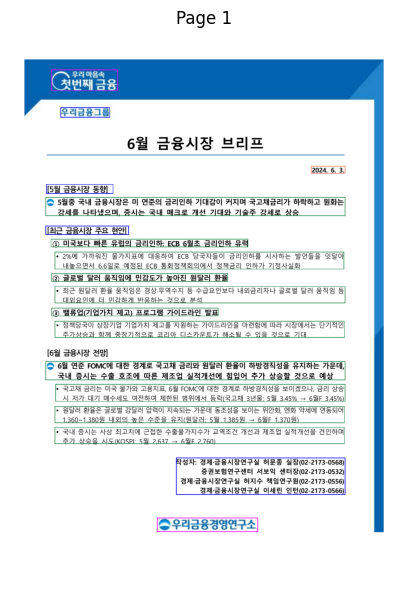

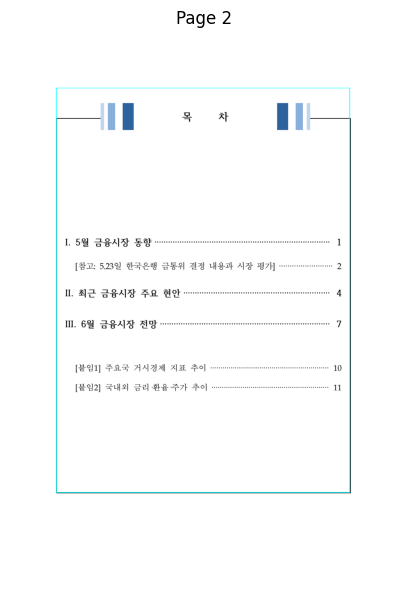

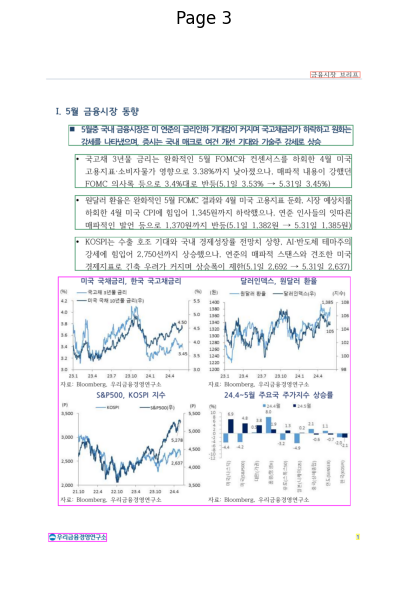

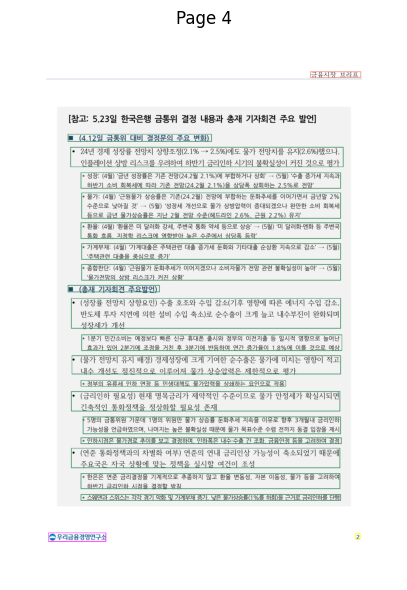

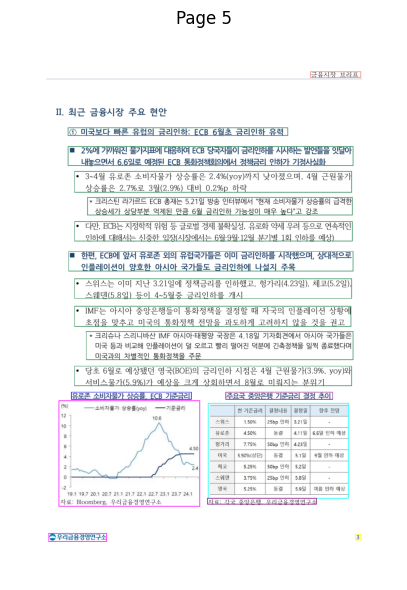

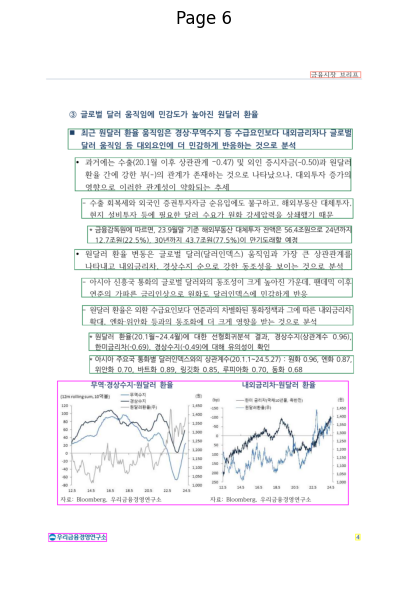

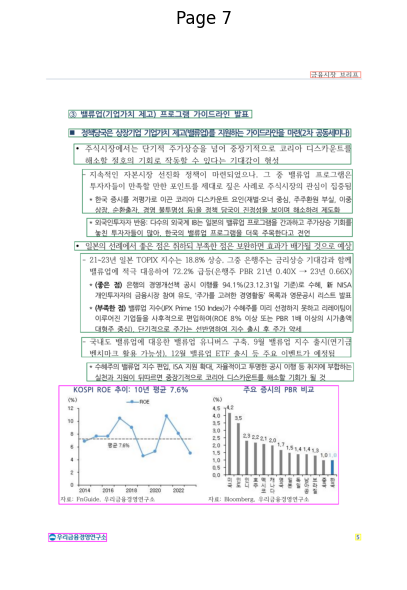

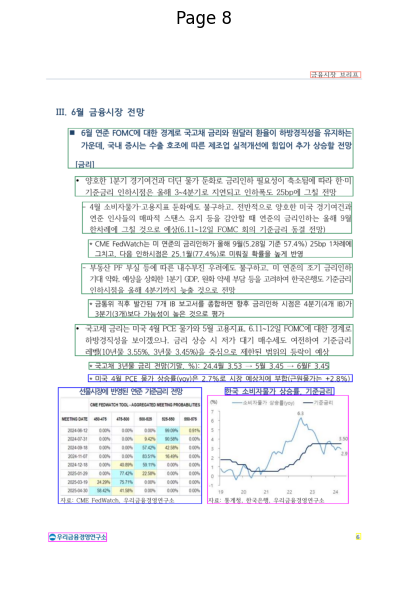

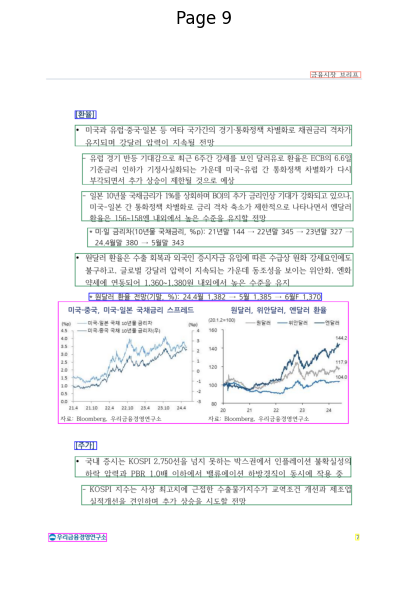

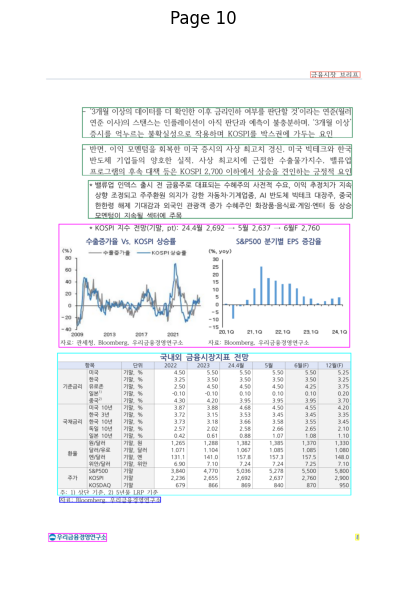

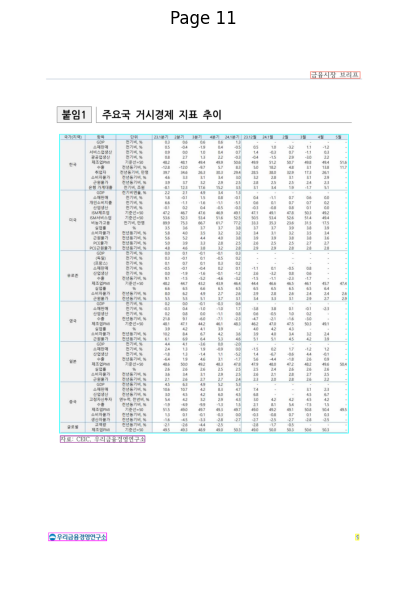

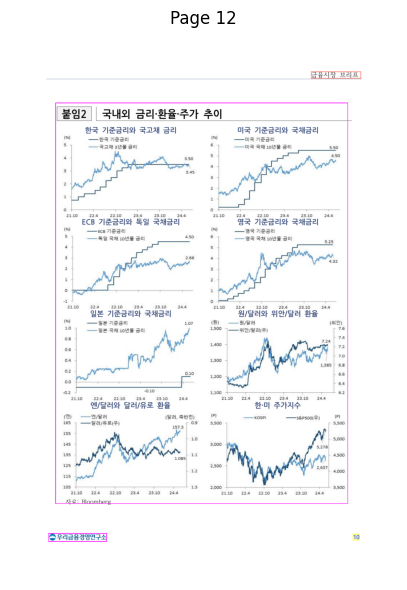

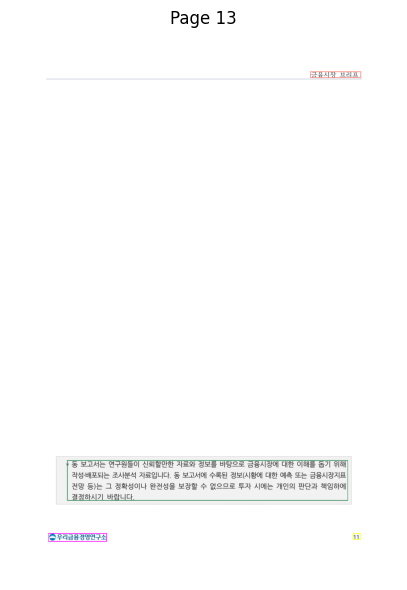

모든 페이지 처리 완료


In [60]:
import pdfplumber
from PyPDF2 import PdfWriter, PdfReader
from reportlab.pdfgen import canvas
from reportlab.lib.colors import Color
from io import BytesIO
from pdf2image import convert_from_bytes
import matplotlib.pyplot as plt

def draw_bboxes_and_display(input_pdf, detection_results):
    with pdfplumber.open(input_pdf) as pdf:
        for page_num, page in enumerate(pdf.pages, start=1):
            # 원본 페이지 읽기
            pdf_reader = PdfReader(input_pdf)
            original_page = pdf_reader.pages[page_num - 1]
            
            # 새 PDF 페이지 생성 (bbox를 그리기 위한 레이어)
            packet = BytesIO()
            can = canvas.Canvas(packet, pagesize=(original_page.mediabox.width, original_page.mediabox.height))
            
            # 현재 페이지에 해당하는 bbox 그리기
            for detection in detection_results:
                for info in detection['info']:
                    if info['page_number'] == page_num:
                        x0, y0, x1, y1 = info['bbox']
                        # PDF 좌표계는 하단이 원점이므로 y 좌표를 변환
                        # print(original_page.mediabox.width)
                        y0 = original_page.mediabox.height - y0
                        y1 = original_page.mediabox.height - y1
                        
                        # layout의 RGB 정보 추출
                        r, g, b = info['layout'].value[2]  # LayoutType enum의 value 속성에서 RGB 추출
                        color = Color(r/255, g/255, b/255)  # reportlab은 0-1 범위의 RGB 값을 사용
                        
                        can.setStrokeColor(color)
                        can.rect(x0, y1, x1 - x0, y0 - y1, fill=0)
            
            can.save()
            
            # 새로 그린 레이어를 원본 페이지에 합치기
            packet.seek(0)
            new_page = PdfReader(packet).pages[0]
            original_page.merge_page(new_page)
            
            # 현재 페이지만 포함하는 새 PDF 작성
            pdf_writer = PdfWriter()
            pdf_writer.add_page(original_page)
            
            # 현재 페이지를 이미지로 변환
            output = BytesIO()
            pdf_writer.write(output)
            output.seek(0)
            images = convert_from_bytes(output.getvalue())
            
            # 현재 페이지 이미지 표시
            plt.figure(figsize=(5, 10))  # A4 비율에 맞춘 크기
            plt.imshow(images[0])
            plt.axis('off')
            plt.title(f'Page {page_num}')
            plt.show()
            
            # 사용자 입력을 기다림
            # input(f"Page {page_num} displayed. Press Enter to continue...")
            plt.close()  # 현재 figure 닫기
    
    print("모든 페이지 처리 완료")

# 사용 예시
file_path="/workspace/.gen/PDF_Parsing/costom_ocr_vgt/src/app/pdf_examples/<vgt>세로형PDF_(20240603) 금융시장 브리프.pdf"
draw_bboxes_and_display(file_path, final_result)

In [ ]:
!

In [61]:
res_check

[[{'page_number': 1,
   'detection_result': [{'bbox': [462.0, 206.0, 514.0, 217.0],
     'page_number': 1,
     'text': '2024.  6.  3.',
     'layout': <LayoutType.Page_header: (6, 'Page header', (250, 128, 114))>,
     'title': ''},
    {'bbox': [179.0, 157.0, 389.0, 183.0],
     'page_number': 1,
     'text': '6월  금융시장  브리프',
     'layout': <LayoutType.Title: (11, 'Title', (255, 165, 0))>},
    {'bbox': [64.0, 58.0, 165.0, 90.0],
     'page_number': 1,
     'text': '',
     'layout': <LayoutType.Picture: (7, 'Picture', (255, 0, 255))>,
     'title': '6월  금융시장  브리프'},
    {'bbox': [78.0, 116.0, 153.0, 131.0],
     'page_number': 1,
     'text': '',
     'layout': <LayoutType.Text: (10, 'Text', (0, 0, 255))>,
     'title': '6월  금융시장  브리프'},
    {'bbox': [56.0, 234.0, 158.0, 248.0],
     'page_number': 1,
     'text': '[5월 금융시장 동향]',
     'layout': <LayoutType.Text: (10, 'Text', (0, 0, 255))>,
     'title': '6월  금융시장  브리프'},
    {'bbox': [55.0, 254.0, 514.0, 282.0],
     'page_number': 

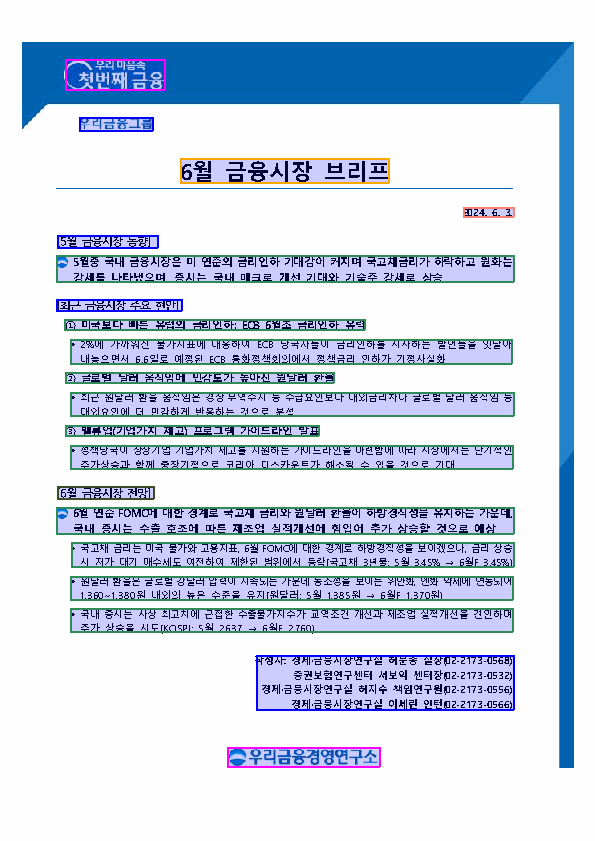

{'bbox': [226.0, 746.0, 380.0, 767.0], 'page_number': 1, 'text': '', 'layout': <LayoutType.Picture: (7, 'Picture', (255, 0, 255))>}


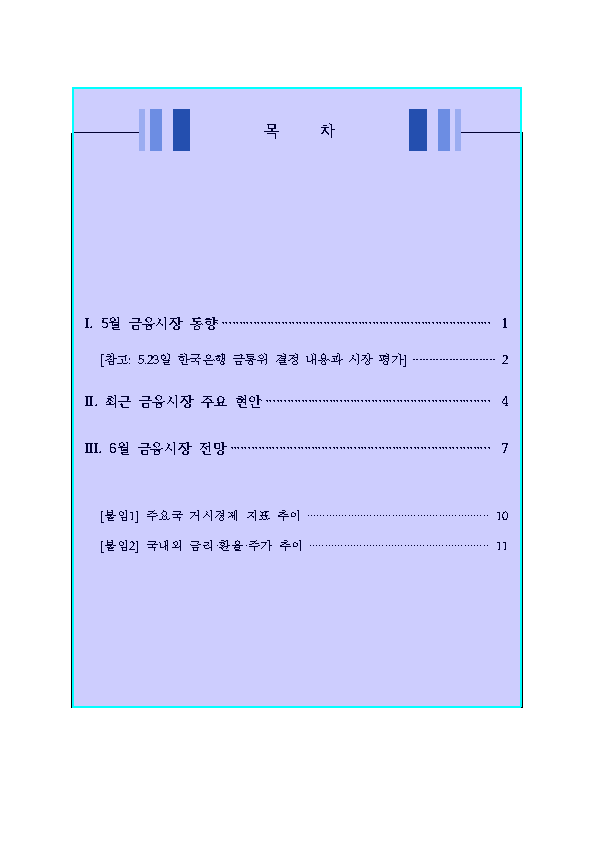

{'bbox': [71.0, 86.0, 521.0, 707.0], 'page_number': 2, 'text': '목          차 I.  5월  금융시장  동향 ·············································································   1 [ 참고 :  5.23 일 한국은행 금통위 결정 내용과 시장 평가 ] ·························   2 II.  최근  금융시장  주요  현안 ································································   4 III.  6월  금융시장  전망 ··········································································   7 [ 붙임 1] 주요국 거시경제 지표 추이 ··························································   10 [ 붙임 2] 국내외 금리 · 환율 · 주가 추이 ·························································   11', 'layout': <LayoutType.Table: (9, 'Table', (0, 255, 255))>, 'title': ''}


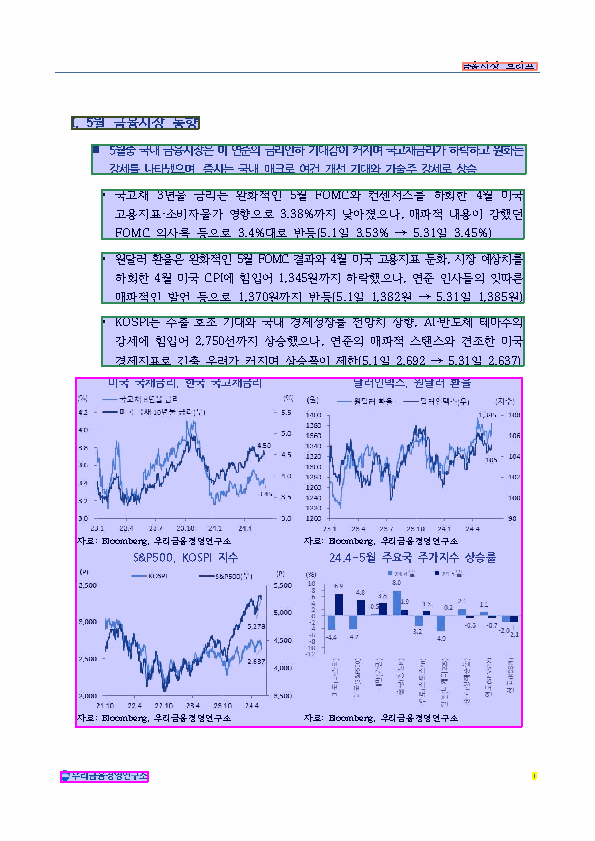

{'bbox': [531.0, 771.0, 536.0, 779.0], 'page_number': 3, 'text': '1', 'layout': <LayoutType.Page_footer: (5, 'Page footer', (255, 255, 0))>}


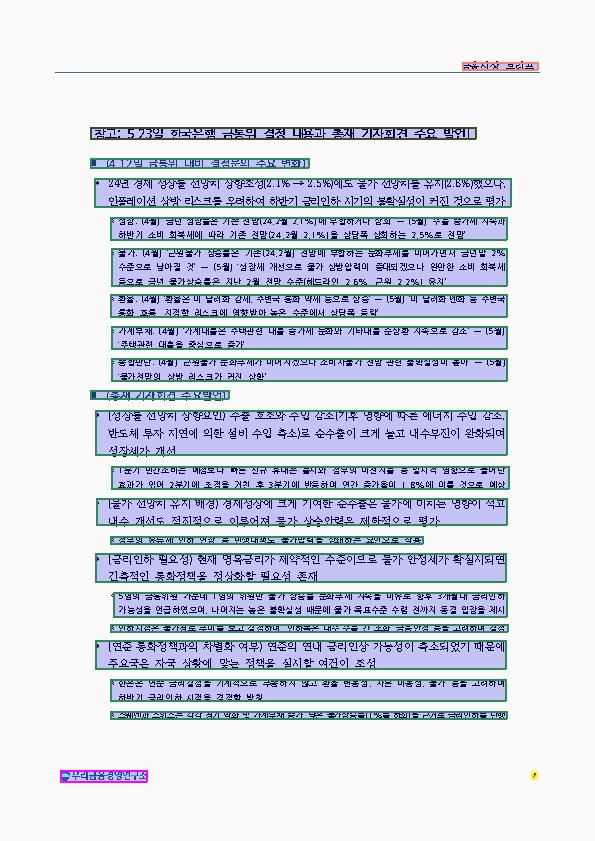

{'bbox': [530.0, 770.0, 537.0, 779.0], 'page_number': 4, 'text': '2', 'layout': <LayoutType.Page_footer: (5, 'Page footer', (255, 255, 0))>}


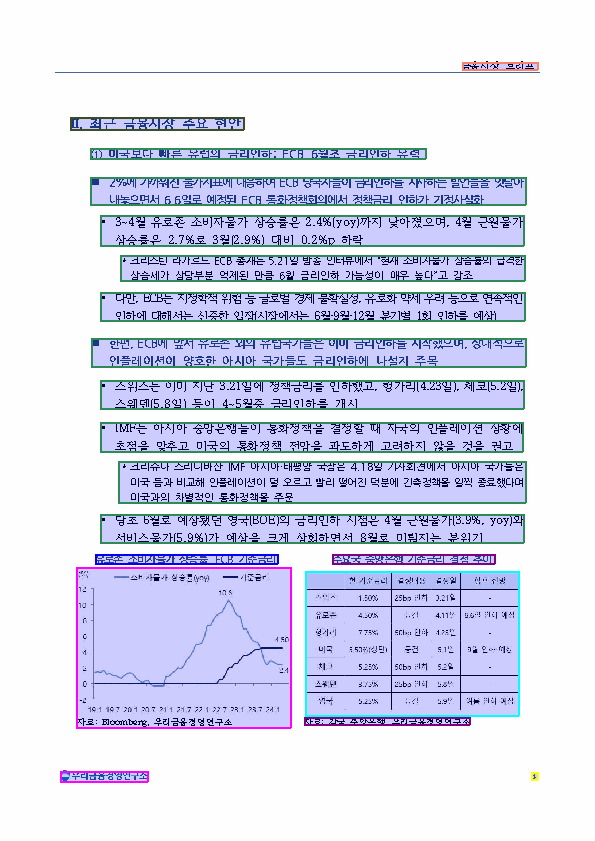

{'bbox': [530.0, 771.0, 538.0, 780.0], 'page_number': 5, 'text': '3', 'layout': <LayoutType.Page_footer: (5, 'Page footer', (255, 255, 0))>}


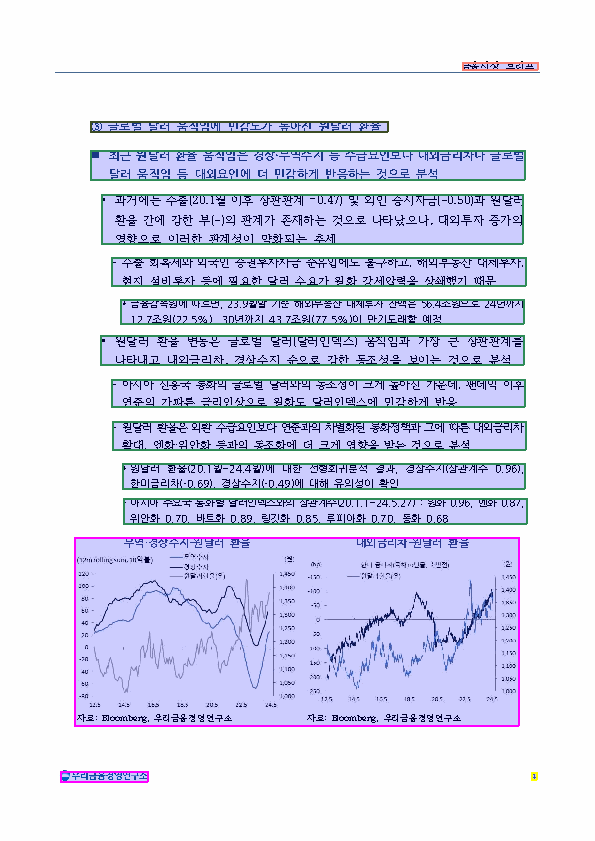

{'bbox': [530.0, 771.0, 537.0, 780.0], 'page_number': 6, 'text': '4', 'layout': <LayoutType.Page_footer: (5, 'Page footer', (255, 255, 0))>}


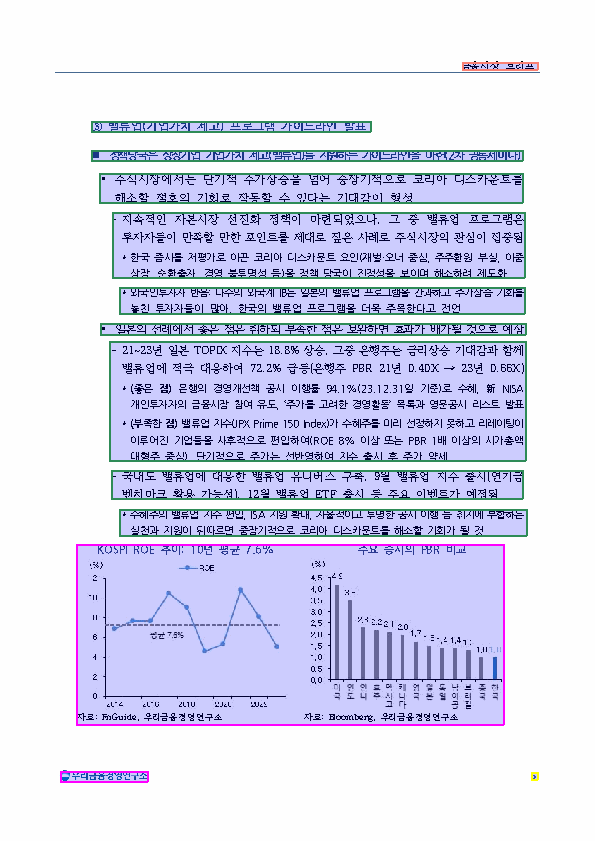

{'bbox': [530.0, 771.0, 538.0, 780.0], 'page_number': 7, 'text': '5', 'layout': <LayoutType.Page_footer: (5, 'Page footer', (255, 255, 0))>}


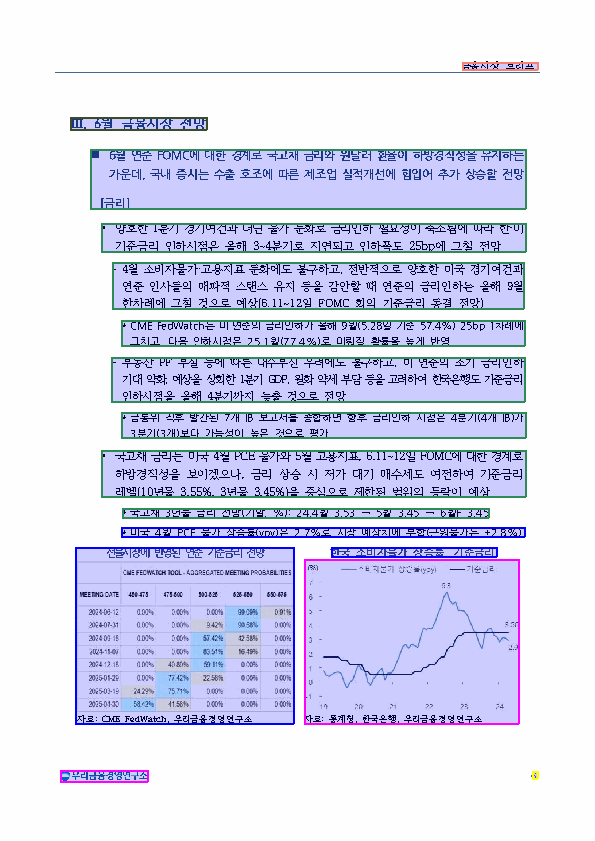

{'bbox': [531.0, 770.0, 538.0, 779.0], 'page_number': 8, 'text': '6', 'layout': <LayoutType.Page_footer: (5, 'Page footer', (255, 255, 0))>}


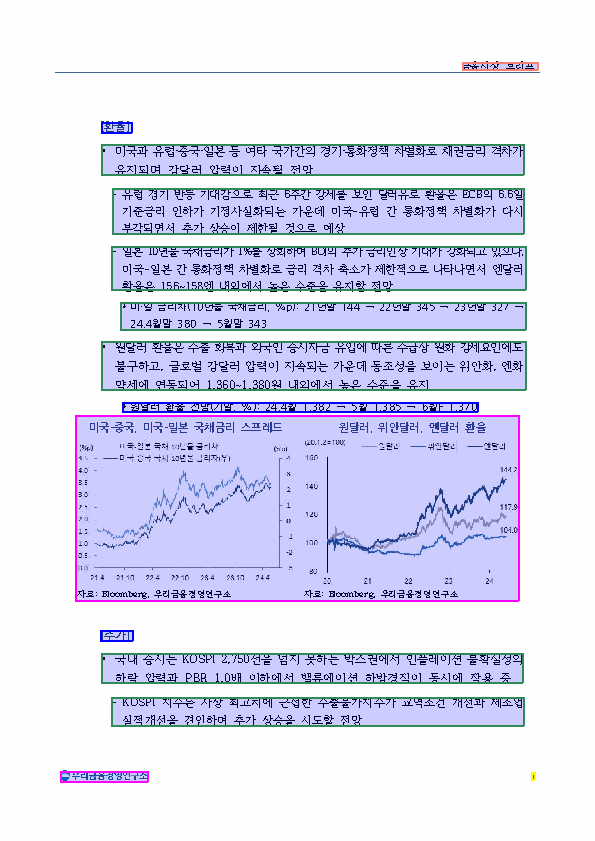

{'bbox': [530.0, 771.0, 535.0, 780.0], 'page_number': 9, 'text': '7', 'layout': <LayoutType.Page_footer: (5, 'Page footer', (255, 255, 0))>}


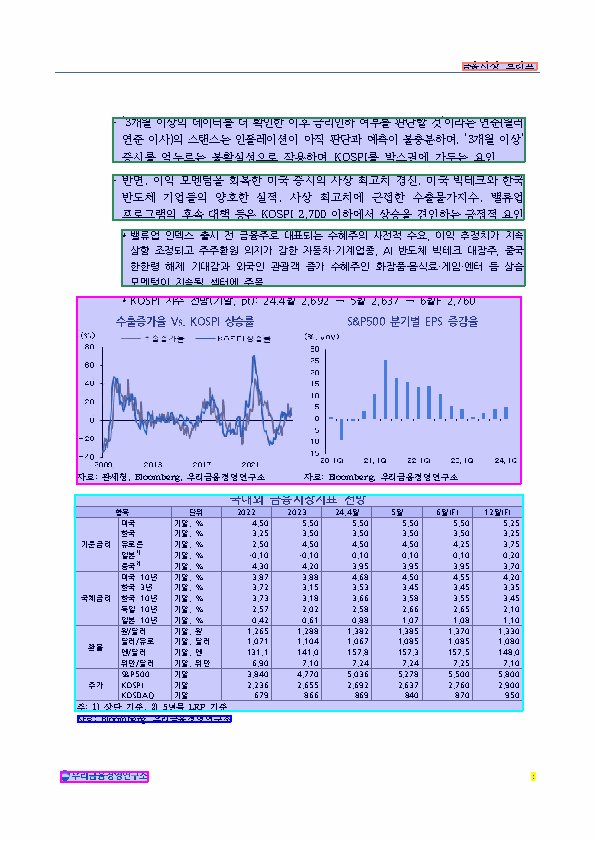

{'bbox': [530.0, 771.0, 535.0, 780.0], 'page_number': 10, 'text': '8', 'layout': <LayoutType.Page_footer: (5, 'Page footer', (255, 255, 0))>}


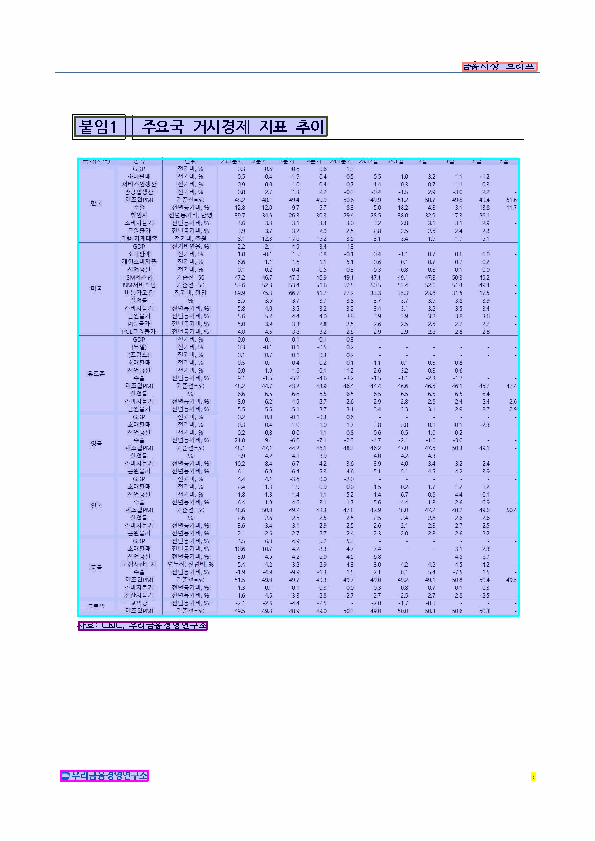

{'bbox': [530.0, 771.0, 535.0, 780.0], 'page_number': 11, 'text': '9', 'layout': <LayoutType.Page_footer: (5, 'Page footer', (255, 255, 0))>}


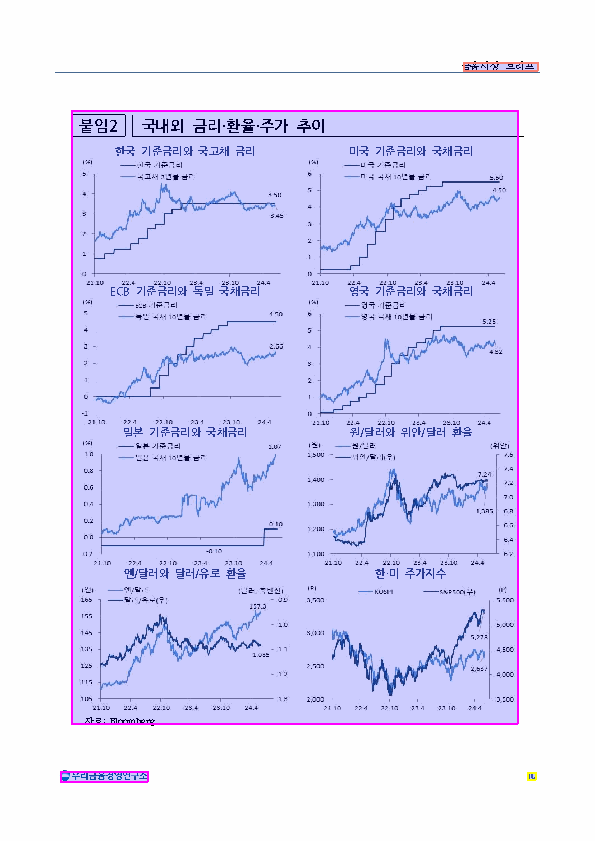

{'bbox': [526.0, 771.0, 536.0, 780.0], 'page_number': 12, 'text': '10', 'layout': <LayoutType.Page_footer: (5, 'Page footer', (255, 255, 0))>}


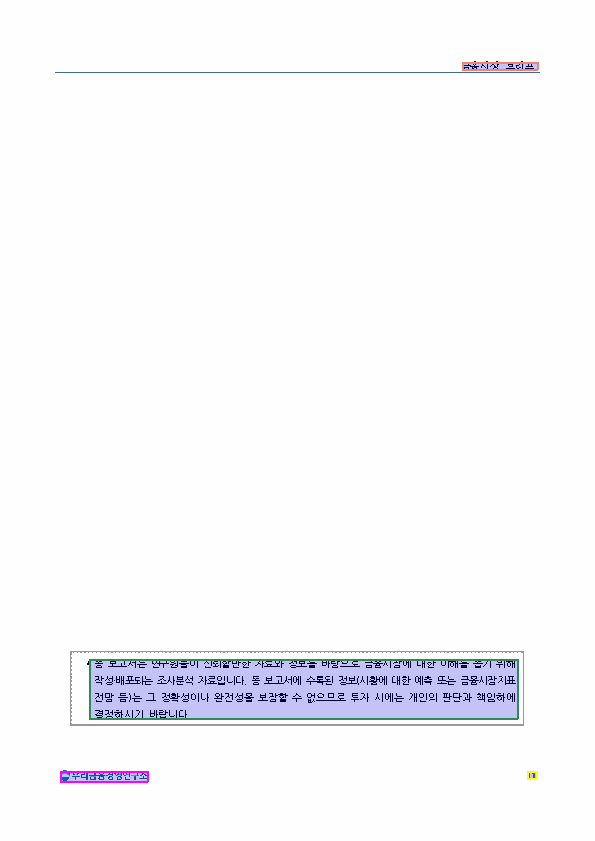

{'bbox': [526.0, 770.0, 537.0, 779.0], 'page_number': 13, 'text': '11', 'layout': <LayoutType.Page_footer: (5, 'Page footer', (255, 255, 0))>}


In [25]:
import re
from PIL import Image, ImageDraw
import pdfplumber

file_path="/workspace/.gen/PDF_Parsing/costom_ocr_vgt/src/app/pdf_examples/<vgt>금융리포트_(20240603) 금융시장 브리프.pdf"
with pdfplumber.open(file_path) as pdf:
    for page_num, page in enumerate(pdf.pages):
        for page_detection_result in res_check[0]:
            if page_num+1==page_detection_result["page_number"]:
            # if page_num==fr["page_num"]:
                im = page.to_image()
                for detection_result in page_detection_result["detection_result"]:
                    bbox=detection_result["bbox"]
                    stroke=detection_result["layout"].__color__
                    im.draw_rect(bbox, stroke=stroke, stroke_width=2)
                    # im.draw_rect({
                    #     "x0": detection_result['left'],
                    #     "top": detection_result['top'],
                    #     "x1": detection_result['left'] + detection_result['width'],
                    #     "bottom": detection_result['top'] + detection_result['height'],
                    #     "stroke": (60, 76, 36),    # 사각형의 색상
                    #     "stroke_width": 5,   # 선의 두께
                    #     "fill":(0,0,0)
                    # })
                display(im)
                print(detection_result)

In [18]:
tuple([1,2,3])

(1, 2, 3)